## Setup Quantification environment

In [1]:
import torch
import matplotlib.pyplot as plt
import os
import torch.nn as nn
from data_preparation import DataHandling 
from datetime import datetime
import json
import numpy as np


## Set dataset path

In [17]:
config_file = 'config.json'

with open(config_file, 'r') as f:
    config = json.load(f)

ga_data_dir = config["ga_data_dir"]
fdg_data_dir = config["fdg_data_dir"]
log_dir = config["log_dir"]
ga_output_dir = config["ga_output_dir"]
artifact_dir = config["artifacts"]
artifact_output = config ["artifact_output"]
fdg_output_dir = config['fdg_output_dir']


In [35]:
import os
import glob
from utils import PairFinder
# hint = 'dl_dyn3'
hint3 = 'gamodel_3_18_onfdg'
# hint = 'gamodel_onfdg'
# hint = 'test_corr2'
# hint = 'comb_3_27_11_26_onfdg'
# hint = 'comb_3_27_11_26_onga'
#hint = 'comb_3_27_11_26_onfdg_spacing'
# hint = 'dl_dyn1'
# hint1 = 'dl3_18'
hint5 = 'comb_3_27_onfdg_v2'
pair_finder_dl3_18 = PairFinder(f'{fdg_data_dir}/MAC', fdg_output_dir, hint5)
all_pairs_dl3_18, c5_pairs_dl3_18, rest_pairs_dl3_18 = pair_finder_dl3_18.find_file_pairs()
print(len(all_pairs_dl3_18), len(c5_pairs_dl3_18), len(rest_pairs_dl3_18))

21 0 21


In [36]:
hint4 = 'dl_final_3_29_v2'
pair_finder_adcm = PairFinder(f'{fdg_data_dir}/MAC', fdg_output_dir, hint4)
all_pairs_adcm, c5_pairs_adcm, rest_pairs_adcm = pair_finder_adcm.find_file_pairs()
print(len(all_pairs_adcm), len(c5_pairs_adcm), len(rest_pairs_adcm))

21 0 21


In [5]:
# import nibabel as nib
# import numpy as np
# import matplotlib.pyplot as plt

# def load_nifti_image(path):
#     """Load a NIfTI image and return its data as a NumPy array."""
#     return nib.load(path).get_fdata()

# def create_mask_from_reference(reference_img, mask_threshold=0.03, scaling_factor=5):
#     """Create a mask from the reference image based on a threshold."""
#     scaled_reference_img = reference_img * scaling_factor
#     mask = scaled_reference_img > mask_threshold
#     return mask

# def apply_mask(image, mask, scaling_factor=5):
#     """Apply the mask to the image."""
#     scaled_image = image * scaling_factor
#     masked_image = np.zeros_like(scaled_image)
#     masked_image[mask] = scaled_image[mask]
#     return masked_image


# def plot_coronal_slice(img, title="Image slice", cmap="jet", slice_idx=None):
#     """Plots a coronal slice of an image."""
#     if slice_idx is None:
#         slice_idx = 70  
#     plt.figure()
#     plt.imshow(img[:, slice_idx, :], cmap=cmap, origin='lower')
#     plt.title(title)
#     plt.axis("off")
#     plt.show()

# # Loop through each pair of images in the list
# for pair in test_dict_list:
#     predicted_img_path = pair['predicted']
#     reference_img_path = pair['reference']
    
#     # Load the images
#     predicted_img = load_nifti_image(predicted_img_path)
#     reference_img = load_nifti_image(reference_img_path)
    
#     # Create a mask from the reference image
#     mask = create_mask_from_reference(reference_img)
    
#     # Apply the same mask to both images
#     masked_predicted_img = apply_mask(predicted_img, mask)
#     masked_reference_img = apply_mask(reference_img, mask)
    
  
#     # # Plot a coronal slice for both masked images
#     # plot_coronal_slice(masked_predicted_img, title=f"Masked Predicted: {predicted_img_path.split('/')[-1]}")
#     # plot_coronal_slice(masked_reference_img, title=f"masked Reference: {reference_img_path.split('/')[-1]}")

#     # plot_coronal_slice(reference_img, title=f"unmasked Reference: {reference_img_path.split('/')[-1]}")

#     break
    

------------------
# Quantification Evaluation

In [34]:
from quant import calculate_metrics_for_pair, aggregate_metrics
# Calculate metrics for each pair and aggregate results
all_metrics_dl3_18 = [calculate_metrics_for_pair(
    pair['predicted'], pair['reference'],
    scaling_factor=7, mask_val = 0.3)
    for pair in all_pairs_dl3_18]

metric_means_sds = aggregate_metrics(all_metrics_dl3_18)

# Print aggregated metrics
for metric, (mean, sd) in metric_means_sds.items():
    print(f"{metric}: {mean:.2f} ± {sd:.4f}")


Mean Error (SUV): -0.48 ± 0.1457
Mean Absolure Error (SUV): 0.70 ± 0.1316
Relative Error (SUV%): -18.30 ± 20.5247
Absolure Relative Error (SUV%): 54.24 ± 9.3453
Root Mean Squared Error: 1.48 ± 0.8662
Peak Signal-to-Noise Ratio: 31.04 ± 5.7015
Structual Similarity Index: 0.79 ± 0.0788


In [31]:
from quant import calculate_metrics_for_pair, aggregate_metrics
# Calculate metrics for each pair and aggregate results
all_metrics_adcm = [calculate_metrics_for_pair(
    pair['predicted'], pair['reference'],
    scaling_factor=1, mask_val = 0.3)
    for pair in all_pairs_adcm]

metric_means_sds = aggregate_metrics(all_metrics_adcm)

# Print aggregated metrics
for metric, (mean, sd) in metric_means_sds.items():
    print(f"{metric}: {mean:.2f} ± {sd:.4f}")


Mean Error (SUV): -0.32 ± 0.1032
Mean Absolure Error (SUV): 0.33 ± 0.0868
Relative Error (SUV%): -55.49 ± 15.6193
Absolure Relative Error (SUV%): 56.98 ± 13.3306
Root Mean Squared Error: 0.48 ± 0.1741
Peak Signal-to-Noise Ratio: 23.92 ± 6.4356
Structual Similarity Index: 0.63 ± 0.1537


comb_3_27_onfdg:
Mean Error (SUV): -0.48 ± 0.1457
Mean Absolure Error (SUV): 0.70 ± 0.1316
Relative Error (SUV%): -18.30 ± 20.5247
Absolure Relative Error (SUV%): 54.24 ± 9.3453
Root Mean Squared Error: 1.48 ± 0.8662
Peak Signal-to-Noise Ratio: 31.04 ± 5.7015
Structual Similarity Index: 0.79 ± 0.0788

comb_3_27_onfdg_v2:
Mean Error (SUV): -0.04 ± 0.0883
Mean Absolure Error (SUV): 0.37 ± 0.0903
Relative Error (SUV%): 2.98 ± 10.5086
Absolure Relative Error (SUV%): 34.29 ± 9.0125
Root Mean Squared Error: 0.71 ± 0.3238
Peak Signal-to-Noise Ratio: 38.23 ± 5.6998
Structual Similarity Index: 0.92 ± 0.0386


dl_final_3_29:
Mean Error (SUV): -0.42 ± 0.0783
Mean Absolure Error (SUV): 0.42 ± 0.0767
Relative Error (SUV%): -72.41 ± 10.2247
Absolure Relative Error (SUV%): 72.65 ± 9.9125
Root Mean Squared Error: 0.57 ± 0.1856
Peak Signal-to-Noise Ratio: 22.53 ± 6.7792
Structual Similarity Index: 0.44 ± 0.1617

dl_final_3_29_v2: 
Mean Error (SUV): -0.32 ± 0.1032
Mean Absolure Error (SUV): 0.33 ± 0.0868
Relative Error (SUV%): -55.49 ± 15.6193
Absolure Relative Error (SUV%): 56.98 ± 13.3306
Root Mean Squared Error: 0.48 ± 0.1741
Peak Signal-to-Noise Ratio: 23.92 ± 6.4356
Structual Similarity Index: 0.63 ± 0.1537

In [25]:
# import matplotlib.pyplot as plt

# metrics_dl3_18 = {metric: [] for metric in all_metrics_dl3_18[0].keys()}
# metrics_adcm = {metric: [] for metric in all_metrics_adcm[0].keys()}

# for entry in all_metrics_dl3_18:
#     for metric, value in entry.items():
#         metrics_dl3_18[metric].append(value)

# for entry in all_metrics_adcm:
#     for metric, value in entry.items():
#         metrics_adcm[metric].append(value)

# # Now, we plot the box plots for each metric.
# # For each metric, we'll have a box plot side by side for the two datasets.

# num_metrics = len(metrics_dl3_18)
# plt.figure(figsize=(5, num_metrics * 2))

# for i, metric in enumerate(metrics_dl3_18.keys(), 1):
#     plt.subplot(num_metrics, 1, i)
#     data_to_plot = [metrics_dl3_18[metric], metrics_adcm[metric]]
#     plt.boxplot(data_to_plot, labels=['dl3_18', 'adcm'])
#     plt.title(metric)

# plt.tight_layout()
# plt.show()


In [42]:
import pandas as pd

metrics_names = list(all_metrics_dl3_18[0].keys())  # Assuming metric names are the same across datasets
combined_data = {metric: {'FL_dl3_18': [], 'ADCM': []} for metric in metrics_names}

for entry in all_metrics_dl3_18:
    for metric, value in entry.items():
        combined_data[metric]['FL_dl3_18'].append(value)

for entry in all_metrics_adcm:
    for metric, value in entry.items():
        combined_data[metric]['ADCM'].append(value)


# Convert your lists of dictionaries into DataFrames for easier manipulation
df_dl3_18 = pd.DataFrame(all_metrics_dl3_18)
df_adcm = pd.DataFrame(all_metrics_adcm)

# Add a column to each dataframe to label the dataset
df_dl3_18['dataset'] = 'FL_dl3_18'
df_adcm['dataset'] = 'ADCM'

# Combine the dataframes
combined_df = pd.concat([df_dl3_18, df_adcm])

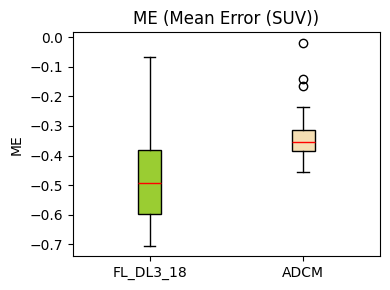

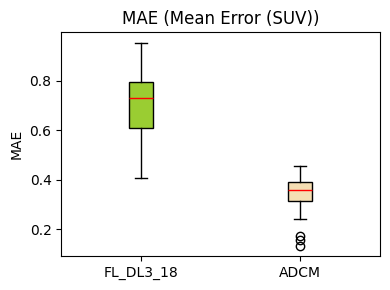

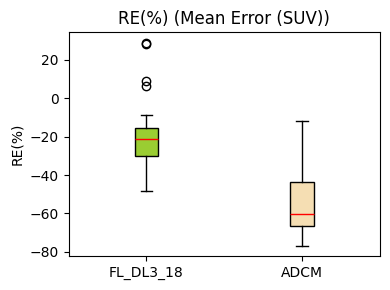

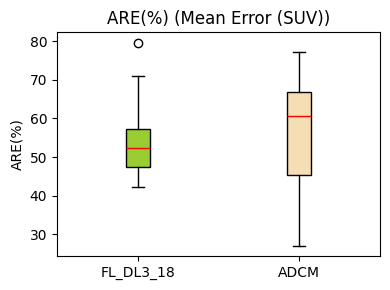

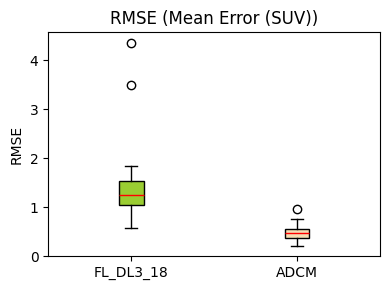

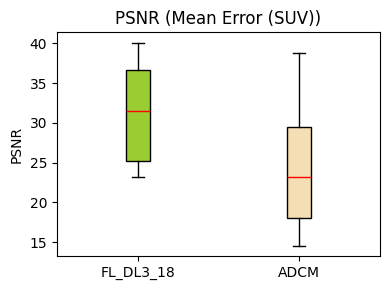

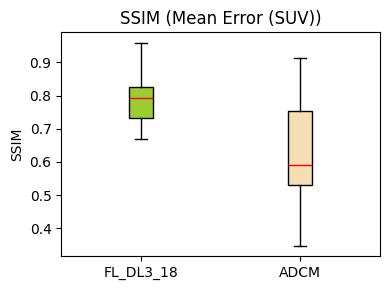

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics_names = list(all_metrics_dl3_18[0].keys())  # Assuming metric names are the same across datasets
subtitle = ['ME','MAE', 'RE(%)', 'ARE(%)', 'RMSE', 'PSNR', 'SSIM']
dataset_colors = {'dl3_18': 'cornflowerblue', 'adcm': 'gold'}  # Colors for each dataset


import matplotlib.pyplot as plt

# Assuming combined_data is already prepared with your data
metrics_names = list(all_metrics_dl3_18[0].keys())  # Metric names from the data
subtitle = ['ME', 'MAE', 'RE(%)', 'ARE(%)', 'RMSE', 'PSNR', 'SSIM']
dataset_colors = ['yellowgreen', 'wheat']  # Colors for each dataset
# lightgreen wheat skyblue 'cornflowerblue', 'gold' palevioletred

for i, metric in enumerate(metrics_names):
    plt.figure(figsize=(4, 3))  # Set the figure size for each individual plot
    data_dl3_18 = combined_data[metric]['FL_dl3_18']
    data_adcm = combined_data[metric]['ADCM']
    
    # Create the boxplot with median line color changed
    bp = plt.boxplot(
        [data_dl3_18, data_adcm],
        patch_artist=True,
        positions=[1, 2],
        medianprops={'color': 'red', 'linewidth': 1}  # Customize the median line here
    )
    
    # Set the face color for each box
    for box, color in zip(bp['boxes'], dataset_colors):
        box.set_facecolor(color)
    
    # Custom x-tick labels
    plt.xticks([1, 2], ['FL_DL3_18', 'ADCM'])
    
    plt.title(f"{subtitle[i]} (Mean Error (SUV))")
    plt.ylabel(subtitle[i])
    
    plt.tight_layout()
    plt.show()  # This will display each plot in a separate figure


In [ ]:
# import matplotlib.pyplot as plt

# # Assuming the structure of all_metrics_dl3_18 and all_metrics_adcm as before,
# # we prepare the data.

# metrics_names = list(all_metrics_dl3_18[0].keys())  # Assuming metric names are the same across datasets
# combined_data = {metric: {'dl3_18': [], 'adcm': []} for metric in metrics_names}

# for entry in all_metrics_dl3_18:
#     for metric, value in entry.items():
#         combined_data[metric]['dl3_18'].append(value)

# for entry in all_metrics_adcm:
#     for metric, value in entry.items():
#         combined_data[metric]['adcm'].append(value)

# # Now, plot violin plots for each metric.
# plt.figure(figsize=(4, 3 * len(metrics_names)))  # Adjust the figure size as needed

# subtitle = ['ME','MAE', 'RE(%)', 'ARE(%)', 'RMSE', 'PSNR', 'SSIM']
# for i, metric in enumerate(metrics_names, 1):
#     plt.subplot(len(metrics_names), 1, i)
    
#     # Prepare the data for violin plot
#     data = [combined_data[metric]['dl3_18'], combined_data[metric]['adcm']]
#     plt.boxplot(data)
#     # plt.violinplot(data, )
    
#     # Adding custom x-tick labels
#     plt.xticks([1, 2], ['dl3_18', 'adcm'])
    
#     plt.title(metric)
#     plt.ylabel(subtitle[i-1])
# plt.tight_layout()
# plt.show()

In [ ]:
# # Define your colors for each category
# color_palette = ['blue', 'red']  # Choose your colors here

# for i, metric in enumerate(metrics):
#     plt.figure(figsize=(4, 3))

#     # Draw violin plots for each category
#     unique_categories = combined_df['dataset'].unique()
#     for j, category in enumerate(unique_categories):
#         category_data = combined_df[combined_df['dataset'] == category]
#         sns.violinplot(x='dataset', y=metric, data=category_data, 
#                        color=color_palette[j], linewidth=0.2, inner='quartile')

#     # Draw box plots for each category
#     for j, category in enumerate(unique_categories):
#         category_data = combined_df[combined_df['dataset'] == category]
#         sns.boxplot(x='dataset', y=metric, data=category_data, showcaps=True, 
#                     boxprops={'facecolor': 'w'}, showfliers=True, 
#                     whiskerprops={'linewidth': 2}, width=0.1, color=color_palette[j])

#     plt.ylabel(subtitle[i], fontsize=12)
#     plt.xlabel('')
#     plt.title(f"{subtitle[i]} ({metric})", fontsize=14)
#     plt.tight_layout()
#     plt.show()


In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from matplotlib.font_manager import FontProperties


# # Convert your lists of dictionaries into DataFrames for easier manipulation
# df_dl3_18 = pd.DataFrame(all_metrics_dl3_18)
# df_adcm = pd.DataFrame(all_metrics_adcm)

# # Add a column to each dataframe to label the dataset
# df_dl3_18['dataset'] = 'dl3_18'
# df_adcm['dataset'] = 'adcm'

# # Combine the dataframes
# combined_df = pd.concat([df_dl3_18, df_adcm])
# legend_font_props = FontProperties()
# legend_font_props.set_size('13')
# # Now, plot box plots for each metric
# metrics = df_dl3_18.columns[:-1]  # Assuming the last column is the 'dataset' label
# subtitle = ['ME','MAE', 'RE(%)', 'ARE(%)', 'RMSE', 'PSNR', 'SSIM']
# for i, metric in enumerate(metrics):
#     plt.figure(figsize=(6, 4))
#     # Create the violin plot without splitting by 'hue'
#     sns.violinplot(x='dataset', y=metric, data=combined_df, palette='Set1', linewidth=0.5, inner=None)
    
#     # Create the box plot separately with adjusted width to be narrower
#     sns.boxplot(x='dataset', y=metric, data=combined_df, showcaps=False, 
#                 boxprops={'facecolor': 'None'}, showfliers=False, 
#                 whiskerprops={'linewidth': 0}, width=0.1)

#     plt.ylabel(subtitle[i], fontsize=12)
#     plt.xlabel('')
#     plt.title(f"ME (Mean Error (SUV))", fontsize=14)
#     plt.tight_layout()
#     plt.show()



------------------------------

In [ ]:
from quant import calculate_metrics_for_pair, aggregate_metrics
# Calculate metrics for each pair and aggregate results
metrics_c5_adcm = [calculate_metrics_for_pair(
    pair['predicted'], pair['reference'],
    scaling_factor=5, mask_val = 0.3)
    for pair in c5_pairs_adcm]

metrics_rest_adcm = [calculate_metrics_for_pair(
    pair['predicted'], pair['reference'],
    scaling_factor=5, mask_val = 0.3)
    for pair in rest_pairs_adcm]

metrics_c5_dl3_18 = [calculate_metrics_for_pair(
    pair['predicted'], pair['reference'],
    scaling_factor=5, mask_val = 0.3)
    for pair in c5_pairs_dl3_18]

metrics_rest_dl3_18 = [calculate_metrics_for_pair(
    pair['predicted'], pair['reference'],
    scaling_factor=5, mask_val = 0.3)
    for pair in rest_pairs_dl3_18]

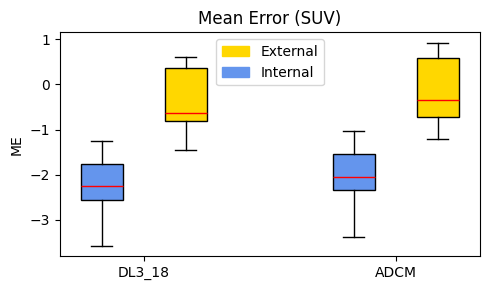

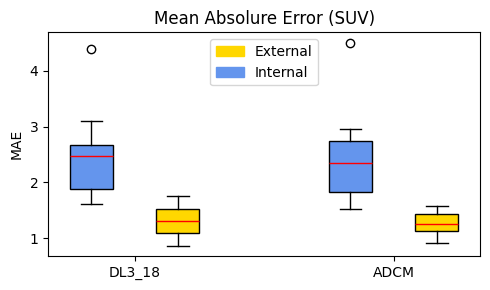

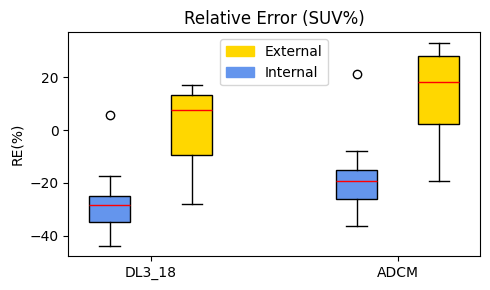

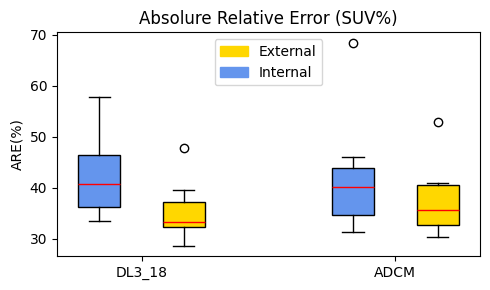

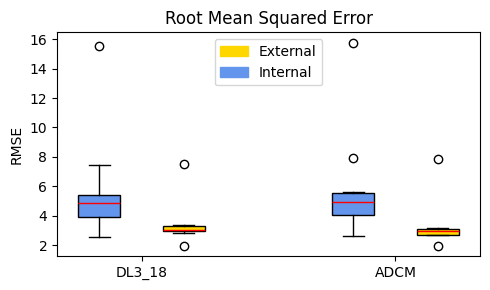

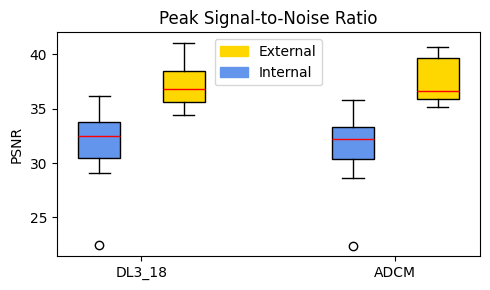

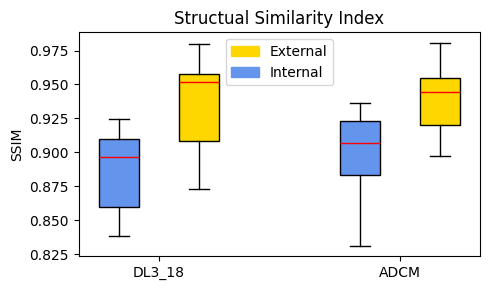

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# Assuming that each metric calculation returns a dictionary like before
metrics_names = list(metrics_c5_adcm[0].keys())  # Metric names from the data
subtitle = ['ME', 'MAE', 'RE(%)', 'ARE(%)', 'RMSE', 'PSNR', 'SSIM']
colors = ['cornflowerblue', 'gold']  # Colors for c5s and rests
# 'lightblue', 'lightcoral'


for i, metric in enumerate(metrics_names):
    plt.figure(figsize=(5, 3))  # Adjust the figure size
    
    # Prepare data for c5s and rests for both datasets
    data_c5_adcm = [entry[metric] for entry in metrics_c5_adcm]
    data_rest_adcm = [entry[metric] for entry in metrics_rest_adcm]
    data_c5_dl3_18 = [entry[metric] for entry in metrics_c5_dl3_18]
    data_rest_dl3_18 = [entry[metric] for entry in metrics_rest_dl3_18]
    
    # Create boxplots
    positions = [1, 2, 4, 5]  # Position for each boxplot
    data = [data_c5_dl3_18, data_rest_dl3_18, data_c5_adcm, data_rest_adcm]
    boxplot_parts = plt.boxplot(data, positions=positions, patch_artist=True,
                                medianprops={'color': 'r', 'linewidth': 1})
    
    # Set colors for each boxplot
    for patch, position in zip(boxplot_parts['boxes'], positions):
        color = colors[0] if position in [1, 4] else colors[1]
        patch.set_facecolor(color)
    
    # Custom x-tick labels
    plt.xticks([1.5, 4.5], ['DL3_18', 'ADCM'])
        # Create custom legend patches
    
    rest_patch = mpatches.Patch(color=colors[0], label='Internal')
    c5_patch = mpatches.Patch(color=colors[1], label='External')


    # Add legend to the plot
    plt.legend(handles=[c5_patch, rest_patch], loc='upper center')
    plt.title(metrics_names[i])
    plt.ylabel(subtitle[i])
    
    plt.tight_layout()
    plt.show()


-----------------

In [7]:
# from quant import extract_suv_values
import numpy as np
import nibabel as nib
def load_nifti_image(path):
    """Load a NIfTI image and return its data as a NumPy array."""
    return nib.load(path).get_fdata()

def extract_suv_values(predicted_path, reference_path, scaling_factor, mask_val):
    """
    Extract SUV values for a single pair of images, applying a scaling factor to the images.
    A mask is applied where the reference image values are bigger than mask_val.
    """
    predicted_img = load_nifti_image(predicted_path) * scaling_factor
    reference_img = load_nifti_image(reference_path) * scaling_factor

    assert predicted_img.shape == reference_img.shape, "Loaded images must have the same shape."

    # Create mask from reference image where values are greater than mask_val
    mask = reference_img > mask_val
    
    # Apply the mask to both images
    masked_predicted_img = predicted_img
    masked_reference_img = reference_img
    
    assert masked_predicted_img.shape == masked_reference_img.shape, "Masked images must have the same shape."

    # Flatten the arrays
    predicted_flat = masked_predicted_img.ravel()
    reference_flat = masked_reference_img.ravel()

    # Final verification
    assert predicted_flat.shape == reference_flat.shape, "Flattened arrays must have the same shape."
    
    return predicted_flat, reference_flat


def gather_suv_values_from_pairs(image_pairs, scaling_factor, mask_val):
    suv_values_predicted = []
    suv_values_reference = []

    for pair in image_pairs:
        predicted_suv, reference_suv = extract_suv_values(
            pair['predicted'],
            pair['reference'],
            scaling_factor,
            mask_val
        )
        suv_values_predicted.extend(predicted_suv)
        suv_values_reference.extend(reference_suv)

    return suv_values_predicted, suv_values_reference

# Gather SUV values for ADCM and DL3_18 datasets
suv_predicted_adcm, suv_reference_adcm = gather_suv_values_from_pairs(all_pairs_adcm, 1, 0.0)
suv_predicted_dl3_18, suv_reference_dl3_18 = gather_suv_values_from_pairs(all_pairs_dl3_18, 1, 0.0)

# Now, you can plot the joint histogram analysis (hexbin plot) for each dataset as shown in the previous example
# ...


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

def create_hexbin_plot(suv_predicted, suv_reference, dataset_label):
    # Calculate regression line and R-squared value
    slope, intercept, r_value, _, _ = linregress(suv_reference, suv_predicted)
    
    # Determine the data range for setting the plot extent
    x_min, x_max = np.min(suv_reference), np.max(suv_reference)
    y_min, y_max = np.min(suv_predicted), np.max(suv_predicted)
    
    # Create the hexbin plot with specified extent
    plt.figure(figsize=(8, 6))
    ax = plt.gca()  # Get the current axes
    # ax.set_facecolor('#280137')
    hb = plt.hexbin(suv_reference, suv_predicted, gridsize=100, cmap='rainbow', bins='log') #,extent=(x_min, x_max, y_min, y_max))
    plt.colorbar(hb, label='log10(N)')

    
    # Plot regression line
    x = np.linspace(x_min, x_max, 100)
    plt.plot(x, slope * x + intercept, color='white', linestyle='dashed', linewidth=2)

    # Annotations for regression line equation and R-squared
    plt.annotate(f'y = {slope:.2f}x + {intercept:.2f}, $R^2$ = {r_value**2:.3f}',
                 xy=(0.05, 0.95), xycoords='axes fraction', 
                 ha='left', va='top', color='black', fontsize=12)

    # Set labels and title
    plt.xlabel('Reference SUV')
    plt.ylabel('Predicted SUV')
    plt.title(f'Joint Histogram Analysis for {dataset_label}')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Generate and show hexbin plots for both datasets
create_hexbin_plot(suv_predicted_adcm, suv_reference_adcm, 'ADCM')

create_hexbin_plot(suv_predicted_dl3_18, suv_reference_dl3_18, 'DL3_18')


ValueError: Inputs must not be empty.

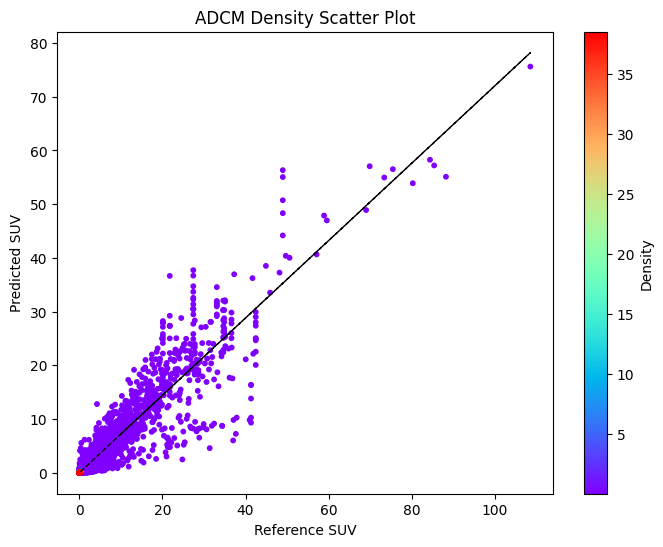

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import gaussian_kde
# from scipy.stats import linregress

# def create_density_scatter_plot(suv_predicted, suv_reference, dataset_label, sample_size=None):
#     # Ensure the data is in the form of 1D NumPy arrays
#     suv_predicted = np.asarray(suv_predicted).flatten()
#     suv_reference = np.asarray(suv_reference).flatten()

#     # Sample the data to speed up the process if needed
#     if sample_size is not None and len(suv_predicted) > sample_size:
#         idx = np.random.choice(len(suv_predicted), size=sample_size, replace=False)
#         suv_predicted = suv_predicted[idx]
#         suv_reference = suv_reference[idx]

#     # Calculate the point density using Gaussian KDE
#     xy = np.vstack([suv_reference, suv_predicted])
#     z = gaussian_kde(xy)(xy)
    
#     # Sort the points by density, so the densest points are plotted last
#     idx = z.argsort()
#     suv_reference, suv_predicted, z = suv_reference[idx], suv_predicted[idx], z[idx]
    
#     # Calculate regression line and R-squared value
#     slope, intercept, r_value, p_value, std_err = linregress(suv_reference, suv_predicted)
#     regression_line = slope * suv_reference + intercept

#     # Create the scatter plot
#     plt.figure(figsize=(8, 6))
#     scatter = plt.scatter(suv_reference, suv_predicted, c=z, s=10, cmap='rainbow')
#     plt.colorbar(scatter, label='Density')
#     plt.plot(suv_reference, regression_line, color='black', linestyle='dashed', linewidth=1)
#     plt.title(f'{dataset_label} Density Scatter Plot')
#     plt.xlabel('Reference SUV')
#     plt.ylabel('Predicted SUV')

#     # Annotation for regression line equation and R-squared
#     plt.annotate(f'y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_value**2:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top', fontsize=12, color='white')

#     # Show plot
#     plt.show()

# # Replace with your actual data
# create_density_scatter_plot(suv_predicted_adcm, suv_reference_adcm, 'ADCM', sample_size=500000)
# create_density_scatter_plot(suv_predicted_dl3_18, suv_reference_dl3_18, 'DL3_18', sample_size=500000)


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import gaussian_kde
# from scipy.stats import linregress

# def create_density_scatter_plot(suv_predicted, suv_reference, dataset_label):
#     # Calculate the point density
#     xy = np.vstack([suv_reference, suv_predicted])
#     z = gaussian_kde(xy)(xy)

#     # Sort the points by density, so that the densest points are plotted last
#     idx = z.argsort()
#     suv_reference, suv_predicted, z = suv_reference[idx], suv_predicted[idx], z[idx]
    
#     # Calculate regression line and R-squared value
#     slope, intercept, r_value, _, _ = linregress(suv_reference, suv_predicted)
#     regression_line = slope * suv_reference + intercept

#     # Create the density scatter plot
#     plt.figure(figsize=(8, 6))
#     scatter = plt.scatter(suv_reference, suv_predicted, c=z, s=50, edgecolor='', cmap='rainbow')
#     plt.colorbar(scatter, label='Density')
    
#     # Plot regression line
#     plt.plot(suv_reference, regression_line, color='red', linestyle='dashed', linewidth=2)

#     # Annotations for regression line equation and R-squared
#     plt.annotate(f'y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_value**2:.3f}',
#                  xy=(0.05, 0.95), xycoords='axes fraction', 
#                  ha='left', va='top', color='red', fontsize=12,
#                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

#     # Set labels and title
#     plt.xlabel('Reference SUV')
#     plt.ylabel('Predicted SUV')
#     plt.title(f'Density Scatter Plot for {dataset_label}')

#     # Show the plot
#     plt.show()

# # Generate and show density scatter plots for both datasets
# create_density_scatter_plot(suv_predicted_adcm, suv_reference_adcm, 'ADCM')
# create_density_scatter_plot(suv_predicted_dl3_18, suv_reference_dl3_18, 'DL3_18')


: 

: 

In [ ]:

# # Plot using seaborn's regplot, which includes a regression line and 95% CI by default
# plt.figure(figsize=(8, 6))
# ax = sns.regplot(x=suv_reference_adcm, y=suv_predicted_adcm, ci=95, color='b', scatter_kws={'alpha':0.3})

# # You can set the facecolor of the axes to match the lowest color in the colormap
# ax.set_facecolor('#280137')  # Adjust the color code to match your colormap's lowest value

# # Labels and title
# plt.xlabel('Reference SUV')
# plt.ylabel('Predicted SUV')
# plt.title('Regression Analysis with 95% CI')

# # Show the plot
# plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Calculate regression values
slope, intercept, r_value, p_value, std_err = stats.linregress(suv_reference_adcm, suv_predicted_adcm)

# Define a function for the regression line
def predict(x):
    return slope * x + intercept

# Predict values along the regression line
line = predict(suv_reference_adcm)

# Calculate the confidence interval
confidence_level = 0.95
degrees_freedom = len(suv_reference_adcm) - 2
t_critical = np.abs(stats.t.ppf((1 - confidence_level) / 2, degrees_freedom))
s_err = np.sum((suv_predicted_adcm - line)**2) / degrees_freedom
conf_interval = t_critical * np.sqrt((s_err/(len(suv_reference_adcm)-1))*(1 + (suv_reference_adcm-np.mean(suv_reference_adcm))**2/np.sum((suv_reference_adcm-np.mean(suv_reference_adcm))**2)))

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(suv_reference_adcm, suv_predicted_adcm, alpha=0.5)
plt.plot(suv_reference_adcm, line, color='red', label=f'Linear Regression\n$y = {slope:.2f}x + {intercept:.2f}$\n$R^2 = {r_value**2:.3f}$')

# Fill the confidence interval
plt.fill_between(suv_reference_adcm, line - conf_interval, line + conf_interval, color='red', alpha=0.2, label='95% Confidence Interval')

# Set the background color
plt.gca().set_facecolor('#280137')

# Labels and title
plt.xlabel('Reference SUV')
plt.ylabel('Predicted SUV')
plt.title('Regression Analysis with 95% CI')
plt.legend()

# Show the plot
plt.show()


TypeError: can't multiply sequence by non-int of type 'numpy.float64'

# Results for Dynunet without matching the networks prameters:
mean_error: -0.25 ± 0.0722
mean_absolute_error: 0.43 ± 0.0803
relative_error: 7.56 ± 7.7195
absolute_relative_error: 38.52 ± 4.3638
rmse: 2.10 ± 0.9815
psnr: 39.60 ± 3.0782
ssim: 0.97 ± 0.0040


# Results for Dyunet with matching the networks prameters:

mean_error: -0.27 ± 0.0802
mean_absolute_error: 0.37 ± 0.0524
relative_error: -14.82 ± 2.6155
absolute_relative_error: 35.17 ± 3.3576
rmse: 1.60 ± 0.3624
psnr: 41.57 ± 2.2030
ssim: 0.97 ± 0.0056


# Resulats for Dyunet after some augmentation:

mean_error: -0.13 ± 0.1053
mean_absolute_error: 0.29 ± 0.1097
relative_error: 11.28 ± 9.1598
absolute_relative_error: 24.58 ± 7.9870
rmse: 1.59 ± 0.9717
psnr: 43.46 ± 4.1015
ssim: 0.98 ± 0.0063

# Results for re-trained model with fdg data on fdg datatest
mean_error: 0.02 ± 0.0064
mean_absolute_error: 0.08 ± 0.0111
relative_error: 6.71 ± 0.0923
absolute_relative_error: 10.90 ± 0.1017
rmse: 0.30 ± 0.0762
psnr: 46.35 ± 6.6213
ssim: 0.98 ± 0.0056